# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss

sys.path.append("Codes/")

import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


c:\Users\anton\OneDrive\_Cloud Disk\Projetos de programação\Git\Transition_Matrix_Process_Drift\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/Synthetic Event Streams - Resource and Data Perspectives (Antonio)/*.csv")

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path).head(30)

How many logs?  3


,0
0,Input/Synthetic/Synthetic Event Streams - Resource and Data Perspectives (Antonio)\recurring_resources_noise0_1000_poc.csv
1,Input/Synthetic/Synthetic Event Streams - Resource and Data Perspectives (Antonio)\recurring_resources_noise0_500_poc.csv
2,Input/Synthetic/Synthetic Event Streams - Resource and Data Perspectives (Antonio)\recurring_time_noise0_1000_baseline.csv


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[0]
print(log_path.split("\\")[-1].split(".")[0])
event_log = pd.read_csv(log_path, delimiter=";")

# Save original event index
event_log = event_log.reset_index(names='original_index') 


# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('case')))
print("Total activities: ", len(event_log.groupby('event')))
event_log.head(15)


recurring_resources_noise0_1000_poc
Total events:  11198
Total cases:  1000
Total activities:  15


,original_index,Event order,case,event,startTime,completeTime,Concept drift,Activity name,Role,Department,Cost,Amount
0,0,0,0,A,2019/01/10 08:00:00,2019/01/10 08:00:00,No,Check application form completeness,Loan Officer,Customer Service,9.9486,9978.7860
1,1,1,1,A,2019/01/10 08:20:00,2019/01/10 08:20:00,No,Check application form completeness,Loan Officer,Customer Service,12.1184,13109.3817
2,2,2,0,B,2019/01/10 08:31:33,2019/01/10 08:31:33,No,Return application back to applicant,Loan Officer,Customer Service,6.9731,9978.7860
3,3,3,2,A,2019/01/10 08:40:00,2019/01/10 08:40:00,No,Check application form completeness,Loan Officer,Customer Service,8.3144,12012.5338
4,4,4,1,D,2019/01/10 08:56:26,2019/01/10 08:56:26,No,Check credit history,Credit Analyst,Customer Service,15.6680,13109.3817
5,5,5,0,C,2019/01/10 08:58:05,2019/01/10 08:58:05,No,Receive updated application,Loan Officer,Customer Service,8.3324,9978.7860
6,6,6,3,A,2019/01/10 09:00:00,2019/01/10 09:00:00,No,Check application form completeness,Loan Officer,Customer Service,9.4452,10560.4655
7,7,7,2,B,2019/01/10 09:05:17,2019/01/10 09:05:17,No,Return application back to applicant,Loan Officer,Customer Service,7.9284,12012.5338
8,8,8,4,A,2019/01/10 09:20:00,2019/01/10 09:20:00,No,Check application form completeness,Loan Officer,Customer Service,12.1763,10783.1078
9,9,9,1,F,2019/01/10 09:28:32,2019/01/10 09:28:32,No,Appraise property,Appraiser,Customer Service,22.3444,13109.3817


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='case', activity_key='event', timestamp_key='startTime', timestamp_format="infer", other_columns_keys=["Role", "Department", "Cost", "Amount"])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(15)

12198


,case_id,activity_from,timestamp_from,Role_from,Department_from,Cost_from,Amount_from,event_order_from,activity_to,timestamp_to,Role_to,Department_to,Cost_to,Amount_to,event_order_to,case_order,transition_id
0,0,START,2019-01-10 08:00:00,Loan Officer,Customer Service,9.9486,9978.7860,0,A,2019-01-10 08:00:00,Loan Officer,Customer Service,9.9486,9978.7860,0.0000,0,0
1,0,A,2019-01-10 08:00:00,Loan Officer,Customer Service,9.9486,9978.7860,0,B,2019-01-10 08:31:33,Loan Officer,Customer Service,6.9731,9978.7860,2.0000,1,1
2,1,START,2019-01-10 08:20:00,Loan Officer,Customer Service,12.1184,13109.3817,1,A,2019-01-10 08:20:00,Loan Officer,Customer Service,12.1184,13109.3817,1.0000,0,2
3,1,A,2019-01-10 08:20:00,Loan Officer,Customer Service,12.1184,13109.3817,1,D,2019-01-10 08:56:26,Credit Analyst,Customer Service,15.6680,13109.3817,4.0000,1,3
4,0,B,2019-01-10 08:31:33,Loan Officer,Customer Service,6.9731,9978.7860,2,C,2019-01-10 08:58:05,Loan Officer,Customer Service,8.3324,9978.7860,5.0000,2,4
5,2,START,2019-01-10 08:40:00,Loan Officer,Customer Service,8.3144,12012.5338,3,A,2019-01-10 08:40:00,Loan Officer,Customer Service,8.3144,12012.5338,3.0000,0,5
6,2,A,2019-01-10 08:40:00,Loan Officer,Customer Service,8.3144,12012.5338,3,B,2019-01-10 09:05:17,Loan Officer,Customer Service,7.9284,12012.5338,7.0000,1,6
7,1,D,2019-01-10 08:56:26,Credit Analyst,Customer Service,15.6680,13109.3817,4,F,2019-01-10 09:28:32,Appraiser,Customer Service,22.3444,13109.3817,9.0000,2,7
8,0,C,2019-01-10 08:58:05,Loan Officer,Customer Service,8.3324,9978.7860,5,A,2019-01-10 09:33:17,Loan Officer,Customer Service,9.4068,9978.7860,10.0000,3,8
9,3,START,2019-01-10 09:00:00,Loan Officer,Customer Service,9.4452,10560.4655,6,A,2019-01-10 09:00:00,Loan Officer,Customer Service,9.4452,10560.4655,6.0000,0,9


## Step 2 - Setting Window Strategy

In [5]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 1000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 100, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items())[:15])

{0: {'start': 0, 'end': 1000, 'window_index': 0},
 1: {'start': 100, 'end': 1100, 'window_index': 1},
 2: {'start': 200, 'end': 1200, 'window_index': 2},
 3: {'start': 300, 'end': 1300, 'window_index': 3},
 4: {'start': 400, 'end': 1400, 'window_index': 4},
 5: {'start': 500, 'end': 1500, 'window_index': 5},
 6: {'start': 600, 'end': 1600, 'window_index': 6},
 7: {'start': 700, 'end': 1700, 'window_index': 7},
 8: {'start': 800, 'end': 1800, 'window_index': 8},
 9: {'start': 900, 'end': 1900, 'window_index': 9},
 10: {'start': 1000, 'end': 2000, 'window_index': 10},
 11: {'start': 1100, 'end': 2100, 'window_index': 11},
 12: {'start': 1200, 'end': 2200, 'window_index': 12},
 13: {'start': 1300, 'end': 2300, 'window_index': 13},
 14: {'start': 1400, 'end': 2400, 'window_index': 14}}

## Step 3 - Setting Process Representation (using Transition Matrix)

In [6]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0
                                    , control_flow_features={'frequency', 'probability', 'causality', 'parallel'}
                                    , time_features={('time_avg','timestamp'), ('time_std','timestamp')}
                                    , resource_features={('categorical_unique', 'Role'), ('categorical_entropy', 'Role')
                                                            , ('categorical_encoding_frequency', 'Role'), ('categorical_encoding_probability', 'Role')
                                                         } 
                                    , data_features={('numerical_avg', 'Amount'), ('numerical_std', 'Amount')
                                                        , ('numerical_avg', 'Cost'), ('numerical_std', 'Cost')
                                                        , ('categorical_unique', 'Department'), ('categorical_entropy', 'Department')
                                                        , ('categorical_encoding_frequency', 'Department'), ('categorical_encoding_probability', 'Department')
                                                    }
                                    ) 

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation().head(15)

frequency  percentual  causality  probability  \
activity_from activity_to                                                  
A             B                 1054      0.0864          1       0.5131   
              D                 1000      0.0820          1       0.4869   
B             C                 1054      0.0864          1       1.0000   
C             A                 1054      0.0864          1       1.0000   
D             F                 1000      0.0820          1       1.0000   
E             G                 1000      0.0820          1       1.0000   
F             E                 1000      0.0820          1       1.0000   
G             H                  491      0.0403          1       0.4910   
              I                  509      0.0417          1       0.5090   
H             END                491      0.0403          1       1.0000   
I             J                  509      0.0417          1       1.0000   
J             K                  253      0.0207          1       0.4971   
              L                  256      0.0210          1       0.5029   
K             M                  253      0.0207          1       1.0000   
L             M                  256      0.0210          1       1.0000   

                           parallel  time_std_timestamp  time_avg_timestamp  \
activity_from activity_to                                                     
A             B                   0             12.1892             21.3098   
              D                   0             12.0318             21.4566   
B             C                   0             12.3641             21.4386   
C             A                   0             12.1040             21.1206   
D             F                   0             12.0727             21.4117   
E             G                   0             12.0530             21.4068   
F             E                   0             11.9128             21.2327   
G             H                   0             12.0902             21.1801   
              I                   0             12.0105             21.6249   
H             END                 0              0.0000              0.0000   
I             J                   0             11.9403             21.5774   
J             K                   0             12.0007             21.7584   
              L                   0             12.1771             21.7368   
K             M                   0             11.9981             21.7931   
L             M                   0             12.0729             21.6479   

                           categorical_unique_Role  \
activity_from activity_to                            
A             B                                  1   
              D                                  1   
B             C                                  1   
C             A                                  1   
D             F                                  1   
E             G                                  2   
F             E                                  2   
G             H                                  1   
              I                                  1   
H             END                                1   
I             J                                  1   
J             K                                  1   
              L                                  2   
K             M                                  1   
L             M                                  2   

                           categorical_encoding_frequency_Role_Appraiser->Credit Analyst  \
activity_from activity_to                                                                  
A             B                                                                        0   
              D                                                                        0   
B             C                                                                        0   
C          

## Step 4 - Setting Change Representation

In [7]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            ### Control Flow Perspective
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            # , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}

            ### Time Perspective
            , 'time_avg_delta' : {'process_feature':'time_avg_timestamp', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'time_std_delta' : {'process_feature':'time_std_timestamp', 'method':'aggregation', 'agg_function' : 'sum'}

            ### Resource Perspective
            , 'role_unique_delta' : {'process_feature':'categorical_unique_Role', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'role_entropy_delta' : {'process_feature':'categorical_entropy_Role', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'role_encoding_frequency_delta' : {'process_feature':'categorical_encoding_frequency_Role', 'method':'multiple_aggregation', 'agg_function' : 'sum'}
            , 'role_encoding_probability_delta' : {'process_feature':'categorical_encoding_probability_Role', 'method':'multiple_aggregation', 'agg_function' : 'sum'}

            ### Data Perspective
            , 'amount_avg_delta' : {'process_feature':'numerical_avg_Amount', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'amount_std_delta' : {'process_feature':'numerical_std_Amount', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'cost_avg_delta' : {'process_feature':'numerical_avg_Cost', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'cost_std_delta' : {'process_feature':'numerical_std_Cost', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'department_unique_delta' : {'process_feature':'categorical_unique_Department', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'department_entropy_delta' : {'process_feature':'categorical_entropy_Department', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'department_encoding_frequency_delta' : {'process_feature':'categorical_encoding_frequency_Department', 'method':'multiple_aggregation', 'agg_function' : 'sum'}
            , 'department_encoding_probability_delta' : {'process_feature':'categorical_encoding_probability_Department', 'method':'multiple_aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            ### Control Flow Perspective
            # 'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}

            ### Time Perspective
            # ,'time_avg_timestamp_gtest_pvalue' : {'process_feature':'time_avg_timestamp', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}

            ### Resource Perspective
            # , 'role_encoding_frequency_gtest_pvalue' : {'process_feature':'categorical_encoding_frequency_Role', 'method':'multiple_g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'role_encoding_probability_gtest_pvalue' : {'process_feature':'categorical_encoding_probability_Role', 'method':'multiple_g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}

            ### Data Perspective
            # , 'amount_avg_gtest_pvalue' : {'process_feature':'numerical_avg_Amount', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'amount_std_gtest_pvalue' : {'process_feature':'numerical_std_Amount', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'cost_avg_gtest_pvalue' : {'process_feature':'numerical_avg_Cost', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'cost_std_gtest_pvalue' : {'process_feature':'numerical_std_Cost', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'department_encoding_frequency_gtest_pvalue' : {'process_feature':'categorical_encoding_frequency_Department', 'method':'multiple_g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            # , 'department_encoding_probability_gtest_pvalue' : {'process_feature':'categorical_encoding_probability_Department', 'method':'multiple_g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}

        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(20)

,start,end,window_index,reference_window_index,frequency_delta,time_avg_delta,time_std_delta,role_unique_delta,role_entropy_delta,role_encoding_frequency_delta,role_encoding_probability_delta,amount_avg_delta,cost_avg_delta,department_unique_delta,department_entropy_delta,department_encoding_frequency_delta,department_encoding_probability_delta
0,0,1000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,1100,1,0,48.0000,3.2131,1.9275,0.0000,0.0000,48.0000,0.0000,2669.6945,1.2903,0.0000,0.0000,48.0000,0.0000
2,200,1200,2,0,32.0000,3.2163,2.3021,0.0000,0.0000,32.0000,0.0000,3974.8531,1.5735,0.0000,0.0000,32.0000,0.0000
3,300,1300,3,0,64.0000,6.3433,3.3955,0.0000,0.0000,64.0000,0.0000,3998.9170,2.3110,0.0000,0.0000,64.0000,0.0000
4,400,1400,4,0,82.0000,7.3965,3.4334,0.0000,0.0000,82.0000,0.0000,5097.9155,2.1624,0.0000,0.0000,82.0000,0.0000
5,500,1500,5,0,84.0000,7.0810,3.6071,0.0000,0.0000,84.0000,0.0000,6139.6344,3.5300,0.0000,0.0000,84.0000,0.0000
6,600,1600,6,0,110.0000,7.2729,4.1143,0.0000,0.0000,110.0000,0.0000,7557.9766,4.2600,0.0000,0.0000,110.0000,0.0000
7,700,1700,7,0,122.0000,7.7862,4.8044,0.0000,0.0000,122.0000,0.0000,8865.9066,4.2984,0.0000,0.0000,122.0000,0.0000
8,800,1800,8,0,134.0000,7.5261,4.8585,0.0000,0.0000,134.0000,0.0000,9041.4477,4.4280,0.0000,0.0000,134.0000,0.0000
9,900,1900,9,0,158.0000,7.6394,5.5271,0.0000,0.0000,158.0000,0.0000,9125.3680,5.3405,0.0000,0.0000,158.0000,0.0000


## Step 5 - Setting Detection Task

In [8]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        ### Control Flow Perspective
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'

        ### Time Perspective
        , 'cpd_time_avg_delta' : {'change_features':['time_avg_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'

        ### Resource Perspective
        , 'cpd_role_unique_delta' : {'change_features':['role_unique_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_role_entropy_delta' : {'change_features':['role_entropy_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_role_encoding_frequency_delta' : {'change_features':['role_encoding_frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_role_encoding_probability_delta' : {'change_features':['role_encoding_probability_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'

        ### Data Perspective
        , 'cpd_amount_avg_delta' : {'change_features':['amount_avg_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_amount_std_delta' : {'change_features':['amount_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_cost_avg_delta' : {'change_features':['cost_avg_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_cost_std_delta' : {'change_features':['cost_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_department_unique_delta' : {'change_features':['department_unique_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        , 'cpd_department_entropy_delta' : {'change_features':['department_entropy_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        , 'cpd_department_encoding_frequency_delta' : {'change_features':['department_encoding_frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
        , 'cpd_department_encoding_probability_delta' : {'change_features':['department_encoding_probability_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1
    }
    , 'threshold_strategy' : 
    {
        ### Control Flow Perspective
        # 'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        # , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}

        ### Time Perspective
        # ,'gtest_time_avg_timestamp' : {'change_features':['time_avg_timestamp_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}

        ### Resource Perspective
        # , 'gtest_role_encoding_frequency' : {'change_features':['role_encoding_frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_role_encoding_probability' : {'change_features':['role_encoding_probability_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}

        ### Data Perspective
        # , 'gtest_amount_avg' : {'change_features':['amount_avg_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_amount_std' : {'change_features':['amount_std_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_cost_avg' : {'change_features':['cost_avg_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_cost_std' : {'change_features':['cost_std_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_department_encoding_frequency' : {'change_features':['department_encoding_frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        # , 'gtest_department_encoding_probability' : {'change_features':['department_encoding_probability_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' :'3'}
        
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[20, 39, 56, 67, 78, 98, 112]"
1,time_series_strategy,cpd_time_avg_delta,"[38, 79, 112]"
2,time_series_strategy,cpd_time_std_delta,"[32, 43, 74, 85, 112]"
3,time_series_strategy,cpd_role_unique_delta,"[32, 43, 72, 84, 112]"
4,time_series_strategy,cpd_role_entropy_delta,"[32, 43, 72, 83, 112]"
5,time_series_strategy,cpd_role_encoding_frequency_delta,"[20, 37, 71, 82, 112]"
6,time_series_strategy,cpd_role_encoding_probability_delta,"[37, 79, 112]"
7,time_series_strategy,cpd_amount_avg_delta,"[37, 78, 112]"
8,time_series_strategy,cpd_cost_avg_delta,"[28, 39, 79, 112]"
9,time_series_strategy,cpd_department_unique_delta,"[31, 43, 72, 84, 112]"


In [9]:
# Grounding truth
log_size = event_log['case'].nunique()
ground_truth_traces_indexes = list(range(int(log_size/3), log_size, int(log_size/3+1)))

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

ground_truth:  [32, 72, 112]


In [10]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan

detection_task_results

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[20, 39, 56, 67, 78, 98, 112]","[32, 72, 112]",0.5000,12.0000
1,time_series_strategy,cpd_time_avg_delta,"[38, 79, 112]","[32, 72, 112]",1.0000,6.5000
2,time_series_strategy,cpd_time_std_delta,"[32, 43, 74, 85, 112]","[32, 72, 112]",0.6700,6.5000
3,time_series_strategy,cpd_role_unique_delta,"[32, 43, 72, 84, 112]","[32, 72, 112]",0.6700,5.7500
4,time_series_strategy,cpd_role_entropy_delta,"[32, 43, 72, 83, 112]","[32, 72, 112]",0.6700,5.5000
5,time_series_strategy,cpd_role_encoding_frequency_delta,"[20, 37, 71, 82, 112]","[32, 72, 112]",0.6700,7.0000
6,time_series_strategy,cpd_role_encoding_probability_delta,"[37, 79, 112]","[32, 72, 112]",1.0000,6.0000
7,time_series_strategy,cpd_amount_avg_delta,"[37, 78, 112]","[32, 72, 112]",1.0000,5.5000
8,time_series_strategy,cpd_cost_avg_delta,"[28, 39, 79, 112]","[32, 72, 112]",0.8000,6.0000
9,time_series_strategy,cpd_department_unique_delta,"[31, 43, 72, 84, 112]","[32, 72, 112]",0.6700,6.0000


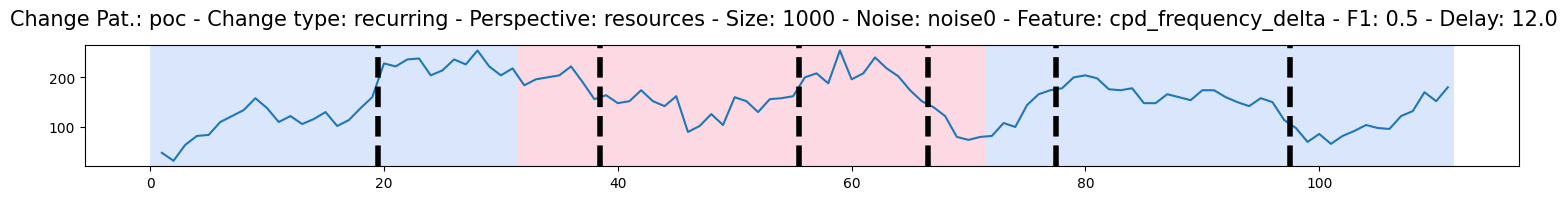

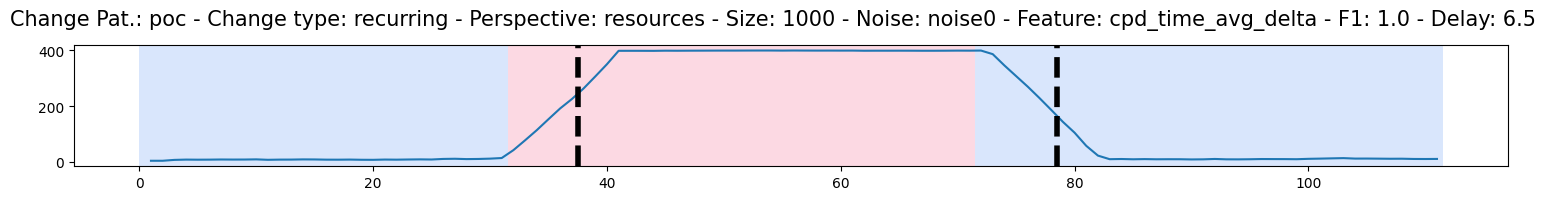

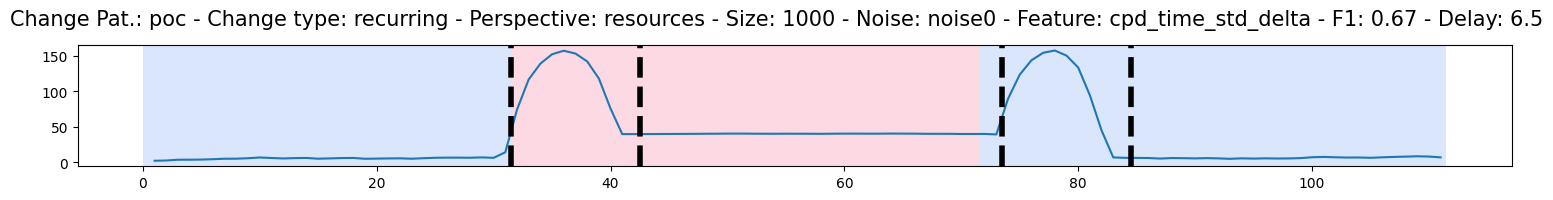

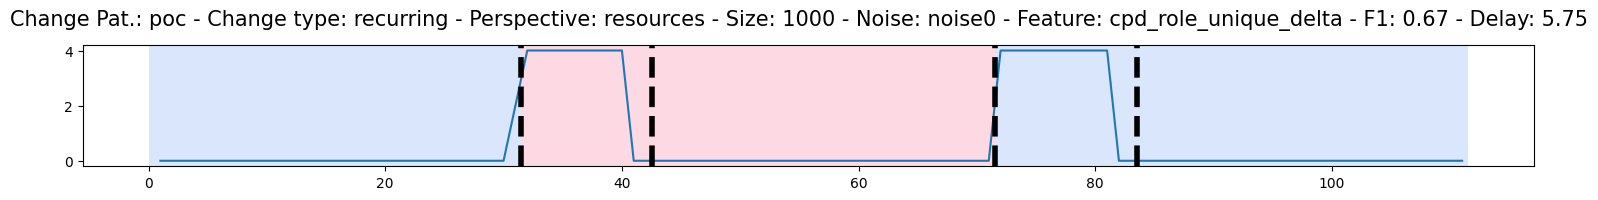

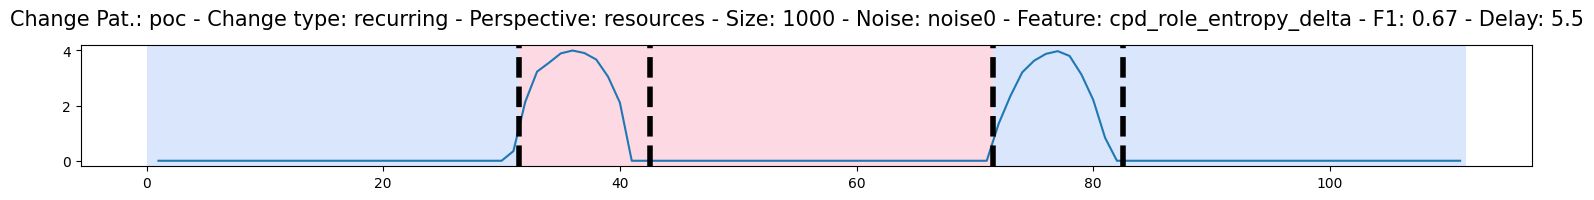

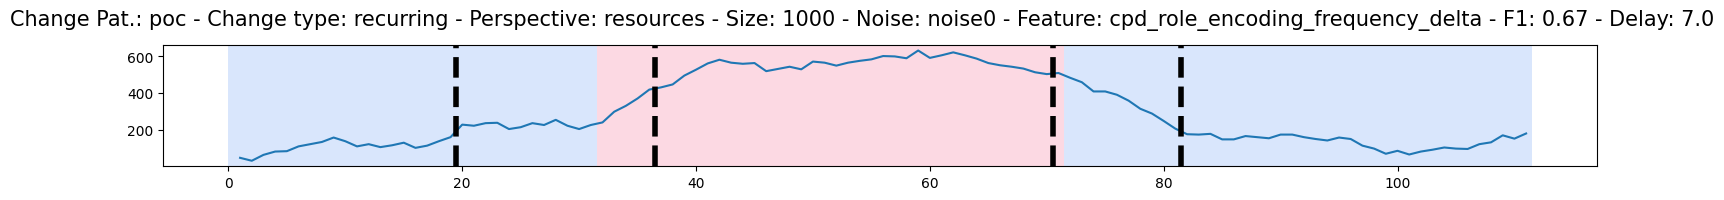

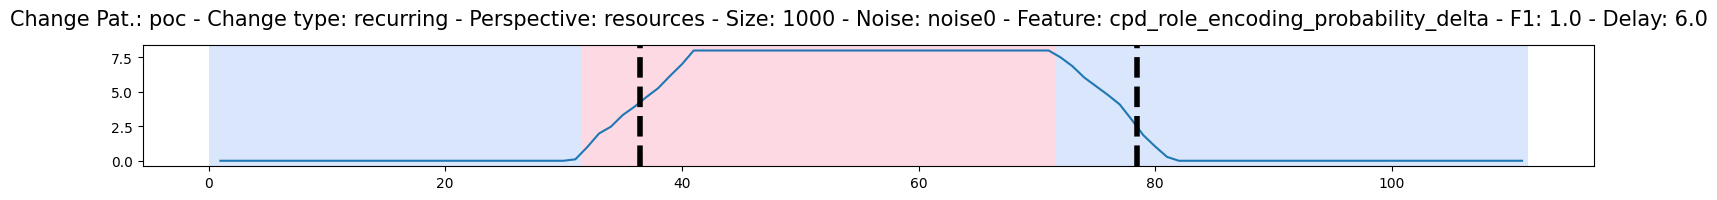

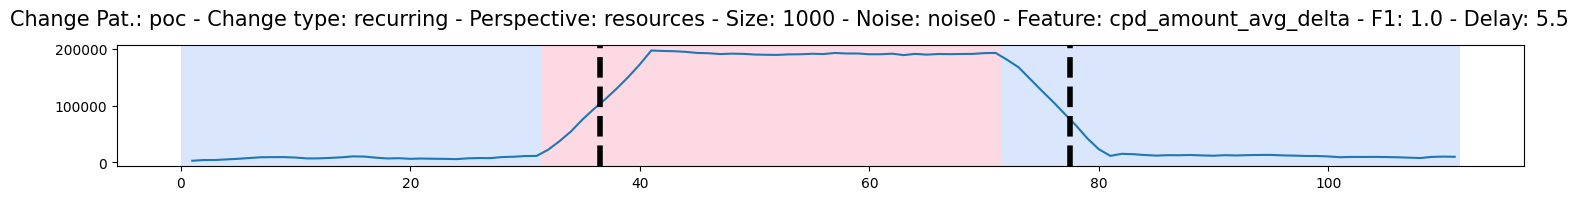

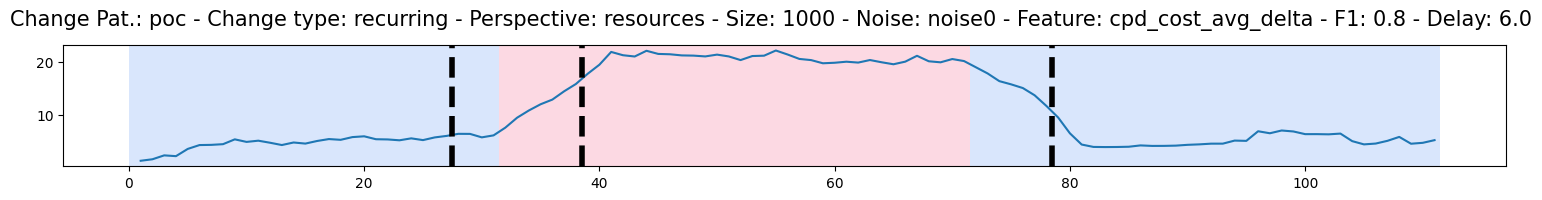

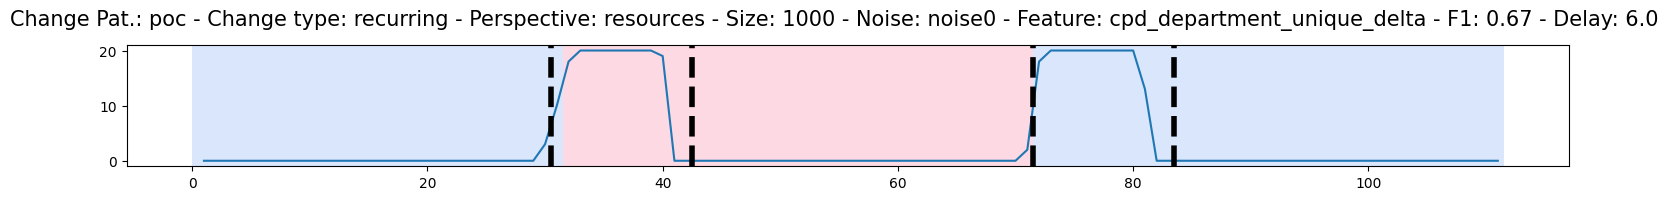

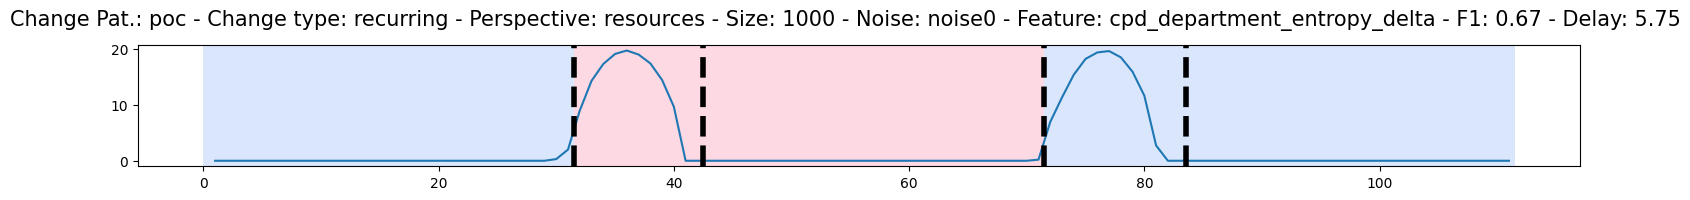

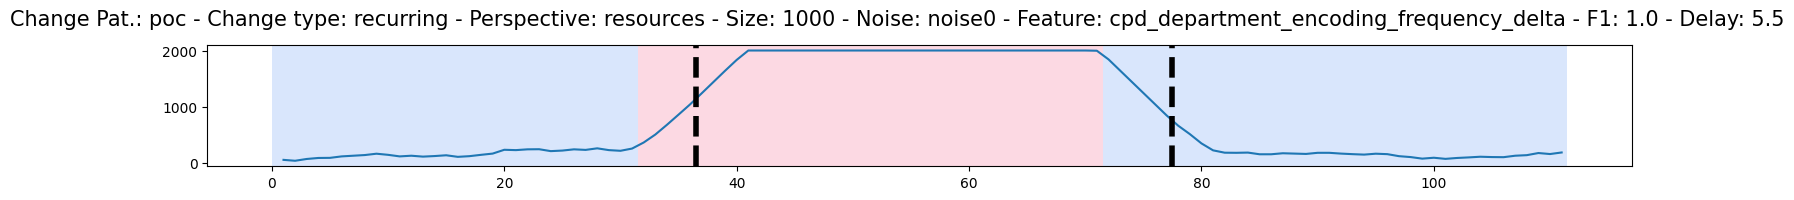

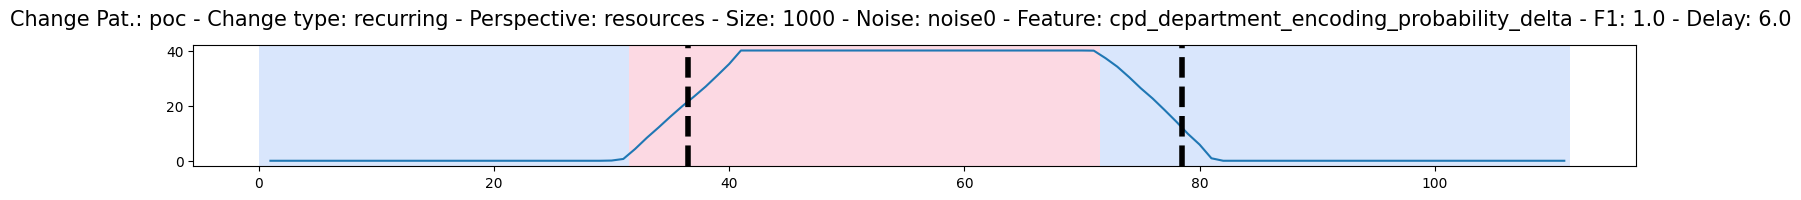

In [11]:
# Display Detection Task Results 
for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change Pat.: " + log_path.split("/")[-1].split("_")[-1].split(".")[0]
                 + " - Change type: " + log_path.split("/")[-1].split("_")[-5].split("\\")[-1]
                 + " - Perspective: " + log_path.split("/")[-1].split("_")[-4]
                 + " - Size: " + log_path.split("/")[-1].split("_")[-2]
                 + " - Noise: " + log_path.split("/")[-1].split("_")[-3] 
                 + " - Feature: " + result.detection_feature
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=15)

    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

In [12]:
# TODO

## Step 6b - Setting Characterization Task

In [13]:
# TODO

## Step 6c - Setting Explanation Task

In [14]:
# TODO